Import Important/Required Python Modules

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
warnings.simplefilter(action="ignore", category=FutureWarning)

Read the Nepal 2015 Earthquake CSV dataset file into memory

In [4]:
#Read our dataset into a pandas data frame
df=pd.read_csv("C:/Users/Raphael.karinguri/Desktop/KARINGURI R/nepal_2015 earthquake/eq2015.csv")

Data Inspection and Cleaning

In [6]:
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   building_id                  762106 non-null  int64 
 1   district_id                  762106 non-null  int64 
 2   vdcmun_id                    762106 non-null  int64 
 3   ward_id                      762106 non-null  int64 
 4   count_floors_pre_eq          762106 non-null  int64 
 5   count_floors_post_eq         762106 non-null  int64 
 6   age_building                 762106 non-null  int64 
 7   plinth_area_sq_ft            762106 non-null  int64 
 8   height_ft_pre_eq             762106 non-null  int64 
 9   height_ft_post_eq            762106 non-null  int64 
 10  land_surface_condition       762106 non-null  object
 11  foundation_type              762106 non-null  object
 12  roof_type                    762106 non-null  object
 13  ground_floor_t

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,damage_grade,technical_solution_proposed,superstructure
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Used in risk,Grade 3,Major repair,has_superstructure_mud_mortar_stone
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 5,Reconstruction,has_superstructure_mud_mortar_stone
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 2,Minor repair,has_superstructure_mud_mortar_stone
3,120101000041,12,1207,120703,1,1,20,312,9,9,...,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 2,Minor repair,has_superstructure_mud_mortar_stone
4,120101000051,12,1207,120703,1,1,30,308,9,9,...,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,Grade 1,Minor repair,has_superstructure_mud_mortar_stone


# Identify and drop any Leakey columns. 
I.e any columns that may have any information regarding a building after the earthquake. We have to drop these columns before building our model because we do not want our model to have any information post the earthquke which might affect it's performance and predictive power.In this case we'll have to drop any post_eq column using a  *'for loop'*.

In [8]:
#Identify leakey columns
leaky_cols=[col for col in df.columns if"post_eq" in col]
#drop columns
df.drop(columns=leaky_cols, inplace=True)
#check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   building_id                  762106 non-null  int64 
 1   district_id                  762106 non-null  int64 
 2   vdcmun_id                    762106 non-null  int64 
 3   ward_id                      762106 non-null  int64 
 4   count_floors_pre_eq          762106 non-null  int64 
 5   age_building                 762106 non-null  int64 
 6   plinth_area_sq_ft            762106 non-null  int64 
 7   height_ft_pre_eq             762106 non-null  int64 
 8   land_surface_condition       762106 non-null  object
 9   foundation_type              762106 non-null  object
 10  roof_type                    762106 non-null  object
 11  ground_floor_type            762106 non-null  object
 12  other_floor_type             762106 non-null  object
 13  position      

# Change categorical columns dtype to object
From the info output above, we notice that there are some categorical columns (building_id,district_id,vdcmun_id,ward_id) that were read into the DF as ints. To ensure that this doesn't affect our model later on, et us conver these columns to str/objects

In [10]:
# Convert categorical ID columns to string (object)
categorical_columns = ['building_id', 'district_id', 'vdcmun_id', 'ward_id']
df[categorical_columns] = df[categorical_columns].astype(str)

# Verify the changes
print(df.dtypes)

building_id                    object
district_id                    object
vdcmun_id                      object
ward_id                        object
count_floors_pre_eq             int64
age_building                    int64
plinth_area_sq_ft               int64
height_ft_pre_eq                int64
land_surface_condition         object
foundation_type                object
roof_type                      object
ground_floor_type              object
other_floor_type               object
position                       object
plan_configuration             object
damage_grade                   object
technical_solution_proposed    object
superstructure                 object
dtype: object


## Identify and Drop High cardinality columns
A high cardinality column is a categorical column that has a large number of unique values relative to the dataset size.

In [12]:
# Display the number of unique values per categorical columns
unique_counts = df[categorical_columns].nunique()
# Print the result
print(unique_counts)

building_id    762106
district_id        11
vdcmun_id         110
ward_id           945
dtype: int64


From these columns, building_id has the highest cardinality (762,094 unique values), making it a strong candidate for removal.

## Why Drop building_id?
Extremely High Cardinality: It’s likely a unique identifier (like an ID column), which doesn’t provide meaningful patterns for a model.
Low Predictive Power: Since it’s unique for almost every record, it won’t generalize well in machine learning.
Encoding Overhead: If used in categorical encoding (e.g., one-hot encoding), it would create a massive number of features, making training inefficient.

In [14]:
#drop high cardinality column
df.drop(columns="building_id", inplace=True)

Inspect the dataset by displaying the null valus per each column in the nepal earthquake dataset

In [16]:
df.isnull().sum()

district_id                     0
vdcmun_id                       0
ward_id                         0
count_floors_pre_eq             0
age_building                    0
plinth_area_sq_ft               0
height_ft_pre_eq                0
land_surface_condition          0
foundation_type                 0
roof_type                       0
ground_floor_type               0
other_floor_type                0
position                        1
plan_configuration              1
damage_grade                   12
technical_solution_proposed    12
superstructure                  0
dtype: int64

It is evident that there are some null values in the position,plan_configuration,damage_grade and technical_solution_proposed columns. Clean the dataset by dropping the null values

In [18]:
df.dropna(inplace=True)


Now that we want to build a binary classification model, we will create a new column "severe_damage" and have it binaries where for building where the damage grade was 4 and above will be represented by 1 and for building with a damage grade below that to be represented by 0.but before that, let's change the datatype for our column from object to int.

In [20]:
#change damage_grade's dtype from object to int
df["damage_grade"]=df["damage_grade"].str[-1].astype(int)
#create a new binary target column named 'severe_damage'
df["severe_damage"]=(df["damage_grade"]>3).astype(int)

now that we have a new column 'severe_damage' which will aid into our binary classification model, let's drop the intitial target column damage_grade

In [22]:
df.drop(columns="damage_grade", inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762094 entries, 0 to 762105
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   district_id                  762094 non-null  object
 1   vdcmun_id                    762094 non-null  object
 2   ward_id                      762094 non-null  object
 3   count_floors_pre_eq          762094 non-null  int64 
 4   age_building                 762094 non-null  int64 
 5   plinth_area_sq_ft            762094 non-null  int64 
 6   height_ft_pre_eq             762094 non-null  int64 
 7   land_surface_condition       762094 non-null  object
 8   foundation_type              762094 non-null  object
 9   roof_type                    762094 non-null  object
 10  ground_floor_type            762094 non-null  object
 11  other_floor_type             762094 non-null  object
 12  position                     762094 non-null  object
 13  plan_configuration 

Identifying what building in our dataset suffered severe damage and those that suffered a damage grade of 3 and below by using our binary target column

In [24]:
print(df["severe_damage"].value_counts())

severe_damage
1    459610
0    302484
Name: count, dtype: int64


## Multicollinearity in Linear Models

**Definition:**  
Multicollinearity occurs when two or more independent variables are highly correlated, making it difficult to determine their individual effects on the dependent variable.

**Effects on a Linear Model:**  
- Leads to **unstable coefficients** and high variance in estimates.  
- Reduces **interpretability** of individual predictors.  
- Increases **standard errors**, making significance testing unreliable.  
- Causes **poor model generalization** to unseen data.  
- May introduce **numerical instability** in computations. 

Now that we'll be building a linear model, we'll have to identify and drop any columns that would bring about multicollinearity. To visualize this, we'll use a correlating heatmap which will help us in identifying numerical columns that might be correlated to each other

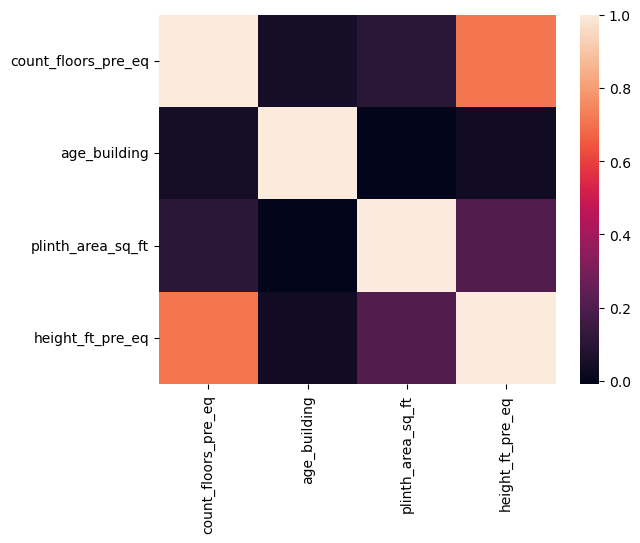

In [27]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation);

From the hatmap above, it is evident tht there is a strong correlation between *count_floors_pre_eq* and *height_ft_pre_eq* and this would bring about a challenge to our model. In this case we'll drop the *count_floors_pre_eq* due to it's higher correlation with our target column

In [29]:
#drop multicollinearity columns
df.drop(columns="count_floors_pre_eq", inplace=True)

## EDA

Are there obvious differences between houses that were severely damaged and those that were not?
Module: seaborn, Viz: boxplot

Text(0.5, 1.0, 'Distribution of Building Height by damage severity')

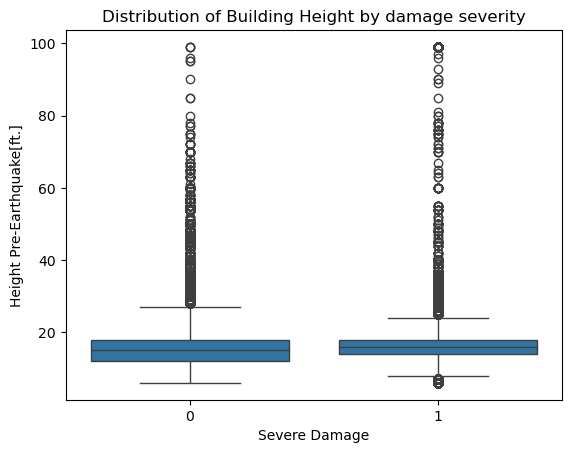

In [32]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
# axes labels uing pyloyt
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-Earthquake[ft.]")
plt.title("Distribution of Building Height by damage severity")

The box plot compares building heights before an earthquake across two damage severity categories (0: Grade ≤ 3, 1: Grade > 4). The median building heights for both categories are similar, with slightly higher variability in severely damaged buildings. Both distributions show a large number of outliers, indicating some very tall buildings. However, the overall height distribution does not show a strong distinction between the two damage severity levels, suggesting that building height alone may not be a key determinant of severe damage.

What's the relative frequency of the buildings that were severely damaged and those that were not?

<Axes: title={'center': 'Severity Class Balance'}, xlabel='Damage Class', ylabel='Relative Frequency'>

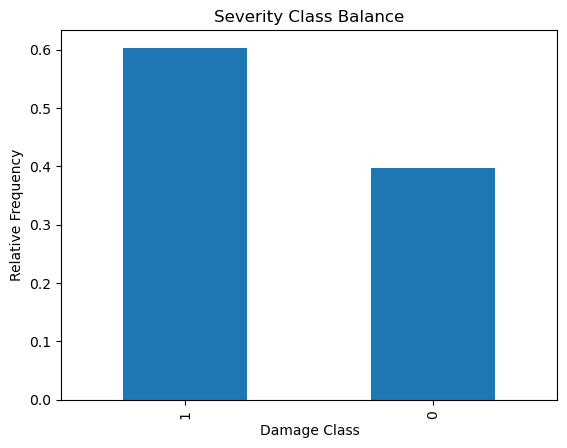

In [35]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Damage Class", ylabel ="Relative Frequency", title="Severity Class Balance"
)

The bar chart shows the relative frequency of buildings that were severely damaged (`1`) versus those that were not (`0`). The majority of buildings (around **60-65%**) fall into the **severely damaged** category, while the remaining **35-40%** experienced **less severe damage**. This indicates that a significant proportion of buildings in the dataset suffered high damage, suggesting potential vulnerability in the construction or environmental factors influencing structural integrity.

Are buildings with certain foundation types more likely to suffer severe damage?

In [38]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
# foundation_type_pivot table
foundation_type_pivot = pd.pivot_table(
    df,index="foundation_type", values="severe_damage", aggfunc=np.mean
)
foundation_type_pivot

,severe_damage
foundation_type,
Bamboo/Timber,0.237855
Cement-Stone/Brick,0.296904
Mud mortar-Stone/Brick,0.685115
Other,0.510545
RC,0.038263


The data reveals that buildings with **mud mortar-stone/brick** foundations are the most vulnerable to severe damage, with 68.5% of them affected, while **reinforced concrete (RC)** foundations are the most resilient, with only 3.8% experiencing severe damage. Foundations categorized as **Other** have an intermediate vulnerability at 51.1%, and **cement-stone/brick** foundations show a moderate vulnerability at 29.7%. Overall, the analysis highlights that mud mortar-stone/brick foundations are most prone to severe damage, whereas RC foundations are least likely to face significant damage.

In [ ]:
df.drop(columns=["district_id","district_id","ward_id","vdcmun_id"], inplace=True)

## Splitting our dataset into training and test data

In [82]:
#our target column
target_column="severe_damage"
#our feature matrix 
X=df.drop(columns=target_column)
#target vector
y=df[target_column]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762094 entries, 0 to 762105
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   age_building                 762094 non-null  int64 
 1   plinth_area_sq_ft            762094 non-null  int64 
 2   height_ft_pre_eq             762094 non-null  int64 
 3   land_surface_condition       762094 non-null  object
 4   foundation_type              762094 non-null  object
 5   roof_type                    762094 non-null  object
 6   ground_floor_type            762094 non-null  object
 7   other_floor_type             762094 non-null  object
 8   position                     762094 non-null  object
 9   plan_configuration           762094 non-null  object
 10  technical_solution_proposed  762094 non-null  object
 11  superstructure               762094 non-null  object
 12  severe_damage                762094 non-null  int32 
dtypes: int32(1), int64(

## Randomized train-test split 
test test:20% of the data. random_state included for reproducibility

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (609675, 12)
y_train shape: (609675,)
X_test shape: (152419, 12)
y_test shape: (152419,)


## Model

In [87]:
#Baseline
y_train.value_counts(normalize=True).max()
#Baseline accuracy score
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.6


A baseline accuracy score of 0.6 means that the model correctly predicts the target variable 60% of the time. This provides a starting point for evaluating the model’s performance, indicating that it performs better than random guessing but still has room for improvement.

In [93]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(solver='lbfgs', max_iter=3000)
)

# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'technical_solution_proposed',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

## Model Evaluation

In [96]:
#Accuracy scores for the training and test models
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.94
Test Accuracy: 0.94


In [110]:
#Feature Importances
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

#Odds Ratio
odds_ratios = pd.Series(np.exp(importances),index=features).sort_values()
odds_ratios.head()

technical_solution_proposed_No need         0.021330
technical_solution_proposed_Minor repair    0.031128
ground_floor_type_Timber                    0.505841
roof_type_RCC/RB/RBC                        0.579002
other_floor_type_TImber/Bamboo-Mud          0.609525
dtype: float64

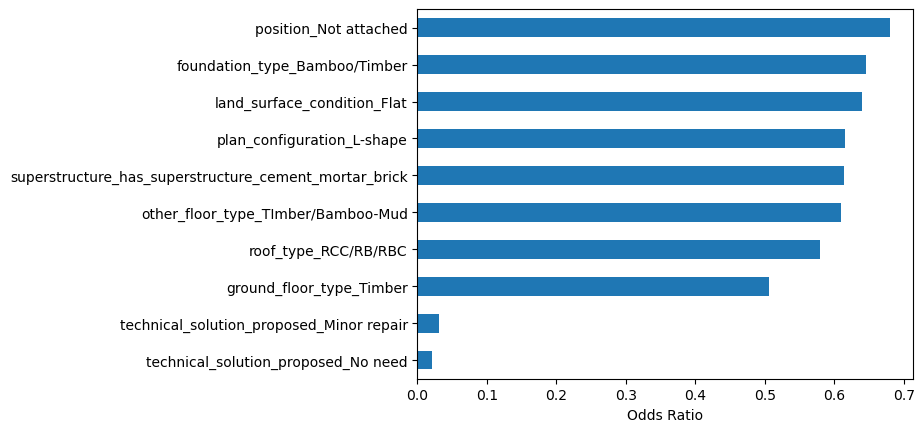

In [121]:
# Horizontal bar chart, 10 largest coefficients
odds_ratios.head(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

Why Calculate the Odds Ratio?
The odds ratio (OR) helps interpret the influence of each feature in a logistic regression model by converting log-odds into a more understandable measure. An OR greater than 1 indicates the feature increases earthquake probability, while an OR less than 1 decreases it. By analyzing the odds ratio, we can identify the most influential factors affecting earthquake risk.

## Interpretation
The bar chart highlights the top 10 features with the highest odds ratios, meaning they have the strongest impact on the model's predictions. The most significant factor is position_Not attached, suggesting that detached buildings are more vulnerable to earthquake damage. Foundation type, construction material, and land surface condition also play crucial roles. Meanwhile, buildings needing minor or no repairs have the lowest odds of being impacted. This insight helps guide structural improvements and risk mitigation efforts.